# Overview
   In Wind Turbines, Scada Systems measure and save data's like wind speed, wind direction, generated power etc. for 10 minutes intervals. This file was taken from a wind turbine's scada system that is working and generating power in Turkey.

# The data are:

- Date/Time (for 10 minutes intervals)
- LV ActivePower (kW): The power generated by the turbine for that moment
- Wind Speed (m/s): The wind speed at the hub height of the turbine (the wind speed that turbine use for electricity generation)
- TheoreticalPowerCurve (KWh): The theoretical power values that the turbine generates with that wind speed which is given by the turbine manufacturer
- Wind Direction (°): The wind direction at the hub height of the turbine (wind turbines turn to this direction automaticly)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [2]:
import mlflow
import logging

In [3]:
data = pd.read_csv(r"C:\Users\hamir\Desktop\Wind Turbine\data\T1.csv")


In [4]:
data.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [5]:
print(data.shape)

(50530, 5)


In [6]:
data['Date/Time'] = pd.to_datetime(data['Date/Time'], format= "%d %m %Y %H:%M")

data['YEAR'] = data['Date/Time'].dt.year
data['MONTH'] = data['Date/Time'].dt.month
data['DAY'] = data['Date/Time'].dt.day
data['hour'] = data['Date/Time'].dt.hour

In [7]:
data = data.drop(['Date/Time'], axis=1)

In [8]:
data.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),YEAR,MONTH,DAY,hour
0,380.047791,5.311336,416.328908,259.994904,2018,1,1,0
1,453.769196,5.672167,519.917511,268.641113,2018,1,1,0
2,306.376587,5.216037,390.900016,272.564789,2018,1,1,0
3,419.645905,5.659674,516.127569,271.258087,2018,1,1,0
4,380.650696,5.577941,491.702972,265.674286,2018,1,1,0


In [9]:
data.isnull().sum()

LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
YEAR                             0
MONTH                            0
DAY                              0
hour                             0
dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   LV ActivePower (kW)            50530 non-null  float64
 1   Wind Speed (m/s)               50530 non-null  float64
 2   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 3   Wind Direction (°)             50530 non-null  float64
 4   YEAR                           50530 non-null  int32  
 5   MONTH                          50530 non-null  int32  
 6   DAY                            50530 non-null  int32  
 7   hour                           50530 non-null  int32  
dtypes: float64(4), int32(4)
memory usage: 2.3 MB


In [11]:
out=[]
def iqr_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for i in df:
        if i > Upper_tail or i < Lower_tail:
            out.append(i)
    print(len(out))

iqr_outliers(data['LV ActivePower (kW)'])
iqr_outliers(data['Theoretical_Power_Curve (KWh)'])
iqr_outliers(data['Wind Direction (°)'])

0
0
0


In [18]:
iqr_outliers(data['Wind Speed (m/s)'])

423


- The data are ready now for modeling 

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X= data.drop(['Wind Speed (m/s)'] , axis = 1).values
y= data['Wind Speed (m/s)' ].values

In [14]:
x_train , x_test , y_train , y_test = train_test_split(X,y , test_size= 0.25 , random_state=42)

# DecisionTreeRegressor

In [15]:
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

mlflow.sklearn.autolog(disable=True)

with mlflow.start_run(run_name='decision tree regressor'):
   
    Regressor = DecisionTreeRegressor()
    Regressor.fit(x_train, y_train)
    yhat = Regressor.predict(x_test)
    mae = mean_absolute_error(y_test, yhat)
    r2 = r2_score(y_test,yhat)
    train_acc = Regressor.score(x_train, y_train)
    test_acc =Regressor.score(x_test, y_test)
    
    mlflow.set_tag("model_name", "RF")
    
    mlflow.log_metric("test_acc", test_acc)
    mlflow.log_metric("train_acc", train_acc)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.sklearn.log_model(Regressor, "sk_models")

In [15]:
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
Regressor = DecisionTreeRegressor()
Regressor.fit(x_train, y_train)
yhat = Regressor.predict(x_test)
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

MAE: 0.168


In [16]:
from sklearn.metrics import r2_score
R2_Decision_Tree = r2_score(y_test,yhat)
print('R2: %.3f' %R2_Decision_Tree)

R2: 0.986


In [ ]:
print(Regressor.score(x_train, y_train))

0.9999996299339289


In [ ]:
ACC_Decision=Regressor.score(x_test, y_test)
print(Regressor.score(x_test, y_test))

0.9859110468316528


# RandomForestRegressor

In [16]:
from sklearn.ensemble import RandomForestRegressor 

mlflow.sklearn.autolog(disable=True)

with mlflow.start_run(run_name='RandomForestRegressor'):
   
    forest_model = RandomForestRegressor(n_estimators=100, max_depth=10)
    forest_model.fit(x_train, y_train )
    
    yhat = forest_model.predict(x_test)
    
    mae = mean_absolute_error(y_test, yhat)
    r2 = r2_score(y_test,yhat)
    train_acc = forest_model.score(x_train, y_train)
    test_acc =forest_model.score(x_test, y_test)
    
    
    mlflow.log_metric("test_acc", test_acc)
    mlflow.log_metric("train_acc", train_acc)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.sklearn.log_model(forest_model, "forest_model")

In [ ]:
from sklearn.ensemble import RandomForestRegressor 
forest_model = RandomForestRegressor(n_estimators=100, max_depth=10)
forest_model.fit(x_train, y_train )
yhat = forest_model.predict(x_test)
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

MAE: 0.171


In [ ]:
R2_Random_Forest = r2_score(y_test,yhat)
print('R2: %.3f' %R2_Random_Forest)

R2: 0.988


In [ ]:
print(forest_model.score(x_train, y_train))

0.9907678636312816


In [ ]:
ACC_Random_Forest=Regressor.score(x_test, y_test)
print(forest_model.score(x_test, y_test))

0.9883074475740993


# XGBRegressor

In [17]:
from xgboost.sklearn import XGBRegressor

mlflow.sklearn.autolog(disable=True)

with mlflow.start_run(run_name='XGBRegressor'):
   
    xgbRegressor = XGBRegressor()
    xgbRegressor.fit(x_train, y_train)
    yhat = xgbRegressor.predict(x_test)
    
    mae = mean_absolute_error(y_test, yhat)
    r2 = r2_score(y_test,yhat)
    train_acc = xgbRegressor.score(x_train, y_train)
    test_acc = xgbRegressor.score(x_test, y_test)
    
    
    mlflow.log_metric("test_acc", test_acc)
    mlflow.log_metric("train_acc", train_acc)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.sklearn.log_model(forest_model, "XGBRegressor")

In [21]:
from xgboost.sklearn import XGBRegressor
xgbRegressor = XGBRegressor()
xgbRegressor.fit(x_train, y_train)
yhat = xgbRegressor.predict(x_test)
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

MAE: 0.178


In [22]:
R2_XGB = r2_score(y_test,yhat)
print('R2: %.3f' %R2_XGB)

R2: 0.990


In [ ]:
print(xgbRegressor.score(x_train, y_train))

0.9948977373685924


In [ ]:
ACC_XGB=xgbRegressor.score(x_test, y_test)
print(xgbRegressor.score(x_test, y_test))

0.9900116112087407


# BayesianRidge

In [ ]:
from sklearn.linear_model import BayesianRidge

brRegressor = BayesianRidge()
brRegressor.fit(x_train, y_train)
yhat = brRegressor.predict(x_test)
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

MAE: 1.014


In [ ]:
print(brRegressor.score(x_train, y_train))

0.8950445458312554


# ExtraTreesRegressor

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
reg = ExtraTreesRegressor(n_estimators=100, random_state=0).fit( x_train, y_train)
yhat = reg.predict(x_test)
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

MAE: 0.121


In [ ]:
R2_ExtraTrees = r2_score(y_test,yhat)
print('R2: %.3f' %R2_ExtraTrees)

R2: 0.994


In [ ]:
print(reg.score(x_train, y_train))

0.9999996299339289


In [ ]:
ACC_ExtraTrees=reg.score(x_test, y_test)
print(reg.score(x_test, y_test))

0.9940636814849906


# LinearRegression

In [ ]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(x_train,y_train)
yhat = linear.predict(x_test)
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

MAE: 1.014


In [ ]:
print(linear.score(x_train, y_train))

0.8950448602438211


# AdaBoostRegressor

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor(n_estimators=20,learning_rate=0.5)
ada.fit(x_train , y_train)

AdaBoostRegressor(learning_rate=0.5, n_estimators=20)

In [ ]:
ada.score(x_train , y_train )

0.9628476211580648

In [ ]:
ACC_Ada=ada.score(x_test , y_test )
ada.score(x_test , y_test )

0.963032343439443

In [ ]:
R2_AdaBoost = r2_score(y_test,yhat)
print('R2: %.3f' %R2_AdaBoost)

R2: 0.896


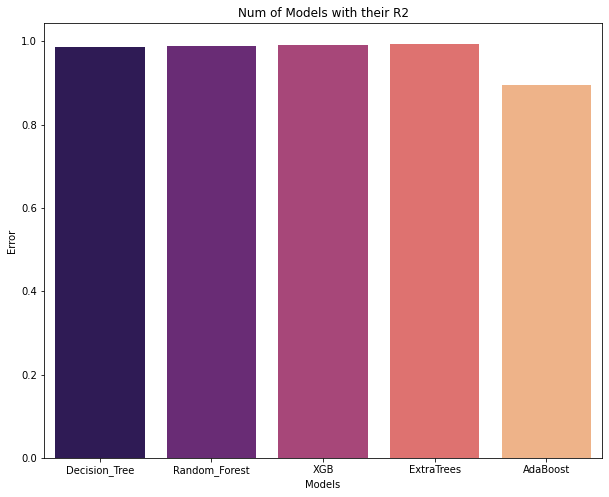

In [ ]:
Error = [R2_Decision_Tree , R2_Random_Forest , R2_XGB , R2_ExtraTrees , R2_AdaBoost]
dataPerf = pd.DataFrame(data={'Models': ['Decision_Tree', 'Random_Forest', 'XGB','ExtraTrees','AdaBoost'] ,
                              'Error': Error ,
                              'Accuracy':[ACC_Decision,ACC_Random_Forest,ACC_XGB,ACC_ExtraTrees,ACC_Ada]})

plt.figure(figsize=(10, 8))
sns.barplot(x="Models", y="Error", data=dataPerf, palette="magma")
plt.title('Num of Models with their R2')
plt.show()

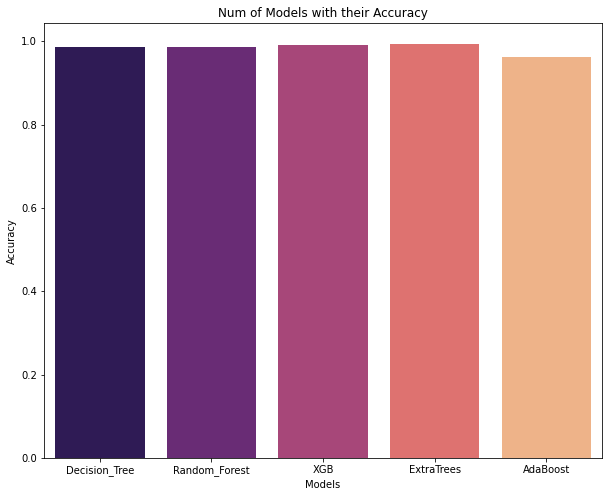

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x="Models", y="Accuracy", data=dataPerf, palette="magma")
plt.title('Num of Models with their Accuracy')
plt.show()